<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install --quiet pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Getting the data

In [ ]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [ ]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [ ]:
FIGSIZE = (20, 20)

In [ ]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [ ]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [ ]:
dataset.shape

(346507, 2)

In [ ]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [ ]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [ ]:
dataset.isnull().sum()

date_time    0
level_cm     0
dtype: int64

In [ ]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [ ]:
dataset.dtypes

level_cm    int64
dtype: object

# Time Series EDA

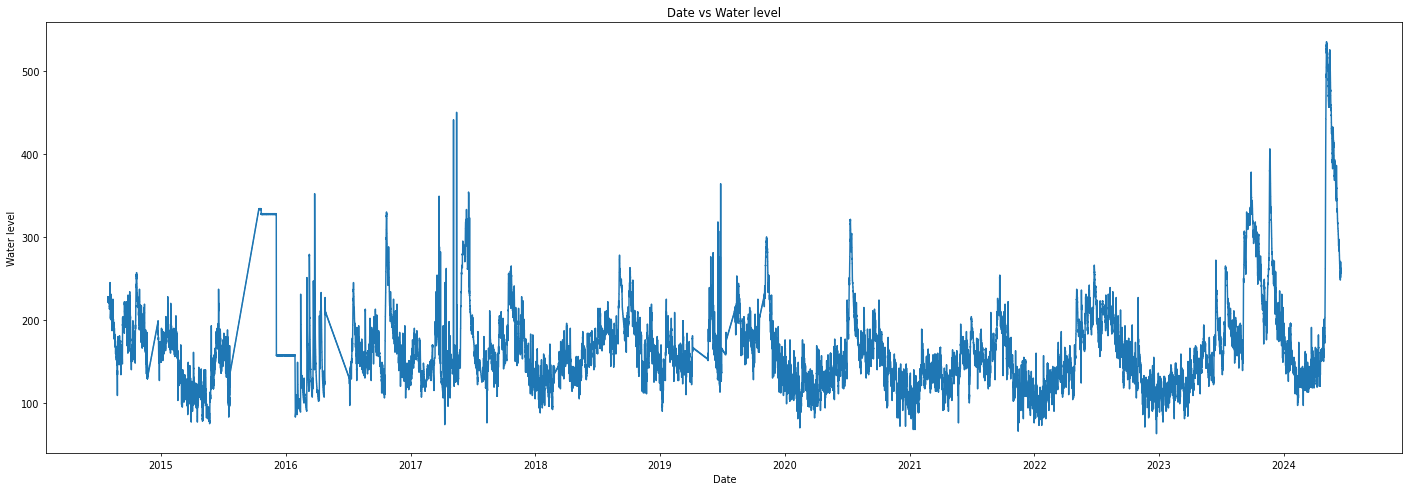

In [ ]:
plot_dataset(dataset.index, dataset['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Selecting time

In [ ]:
# Definir a faixa de datas
start_date = '2020-01-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

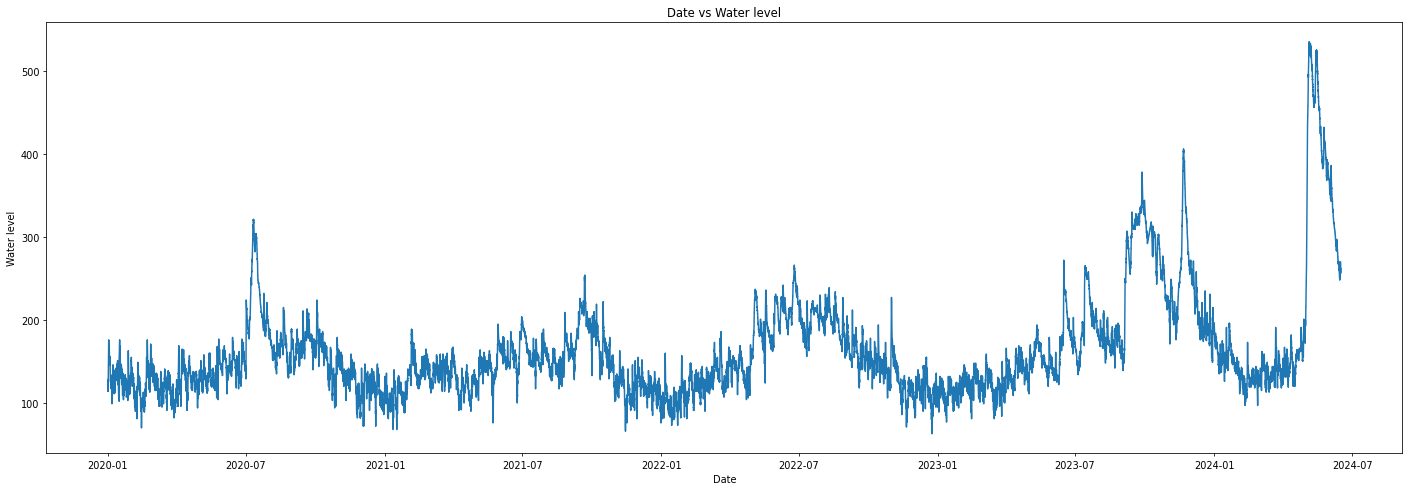

In [ ]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

## Time Series Decomposition

In [ ]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

In [ ]:
result = seasonal_decompose(df_lag['level_cm'], model='additive', period=96)
result.plot()
plt.show()

In [ ]:
result.trend.plot()

In [ ]:
result.seasonal.plot()

In [ ]:
residual = result.resid
residual.plot()

## Making the series stationary

In [ ]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [ ]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [ ]:
print("Level_cm")
check_stationarity(df_filtered['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.681128
p-value: 0.000091
Critical values: 
	1%: -3.430392
	5%: -2.861559
	10%: -2.566780


### Transforming data

In [ ]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_filtered['level_cm'] - df_filtered['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2020-01-01 00:15:00,2.0
2020-01-01 00:30:00,0.0
2020-01-01 00:45:00,-1.0
2020-01-01 01:00:00,0.0
2020-01-01 01:15:00,0.0
...,...
2024-06-15 23:00:00,1.0
2024-06-15 23:15:00,1.0
2024-06-15 23:30:00,0.0


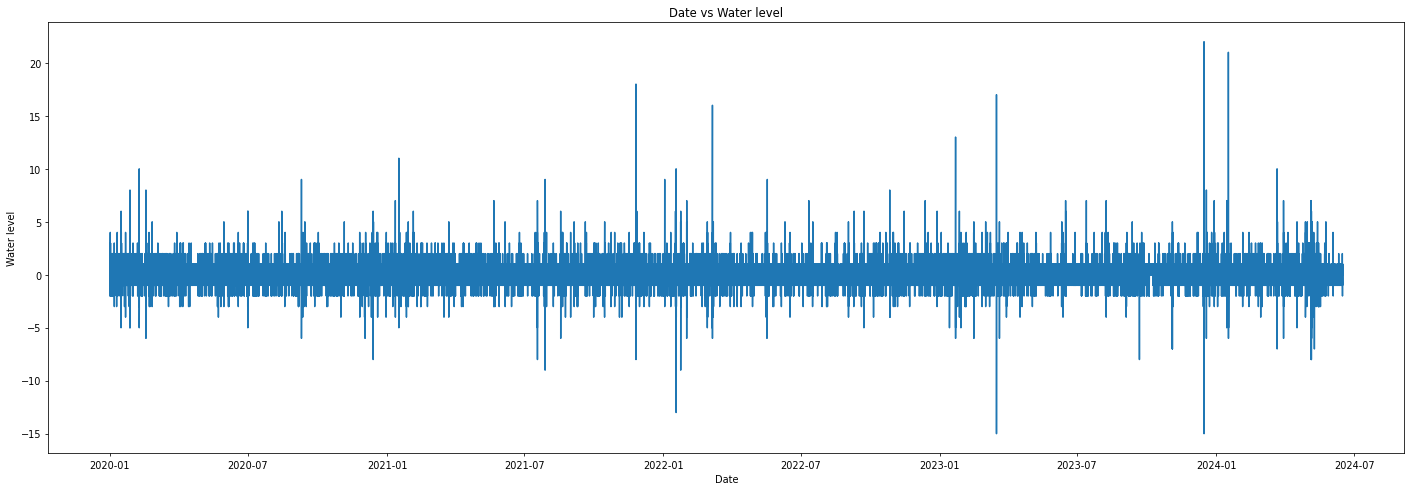

In [ ]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [ ]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -46.821859
p-value: 0.000000
Critical values: 
	1%: -3.430392
	5%: -2.861559
	10%: -2.566780


**Using ACF and PACF level_cm**

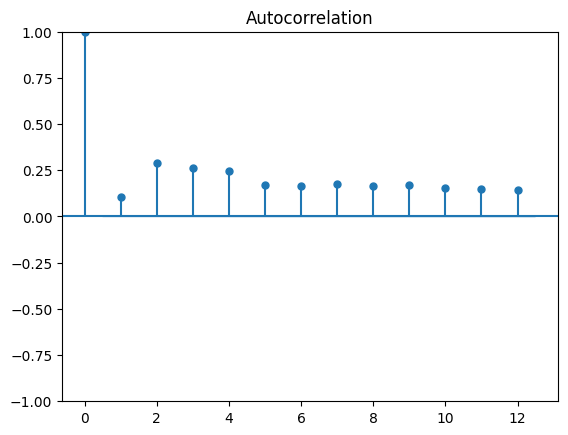

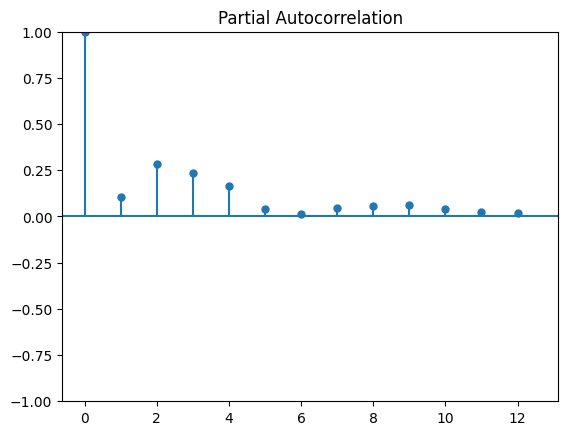

In [ ]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

# Training the model

### Scaling the data

In [ ]:
data = df_lag['level_cm_lag_1'].values
data

array([ 2.,  0., -1., ...,  0.,  1.,  0.])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
data_scaled

array([0.45945946, 0.40540541, 0.37837838, ..., 0.40540541, 0.43243243,
       0.40540541])

In [ ]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] =data_scaled
df_scaled.index = df_lag.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2020-01-01 00:15:00,0.459459
2020-01-01 00:30:00,0.405405
2020-01-01 00:45:00,0.378378
2020-01-01 01:00:00,0.405405
2020-01-01 01:15:00,0.405405
...,...
2024-06-15 23:00:00,0.432432
2024-06-15 23:15:00,0.432432
2024-06-15 23:30:00,0.405405


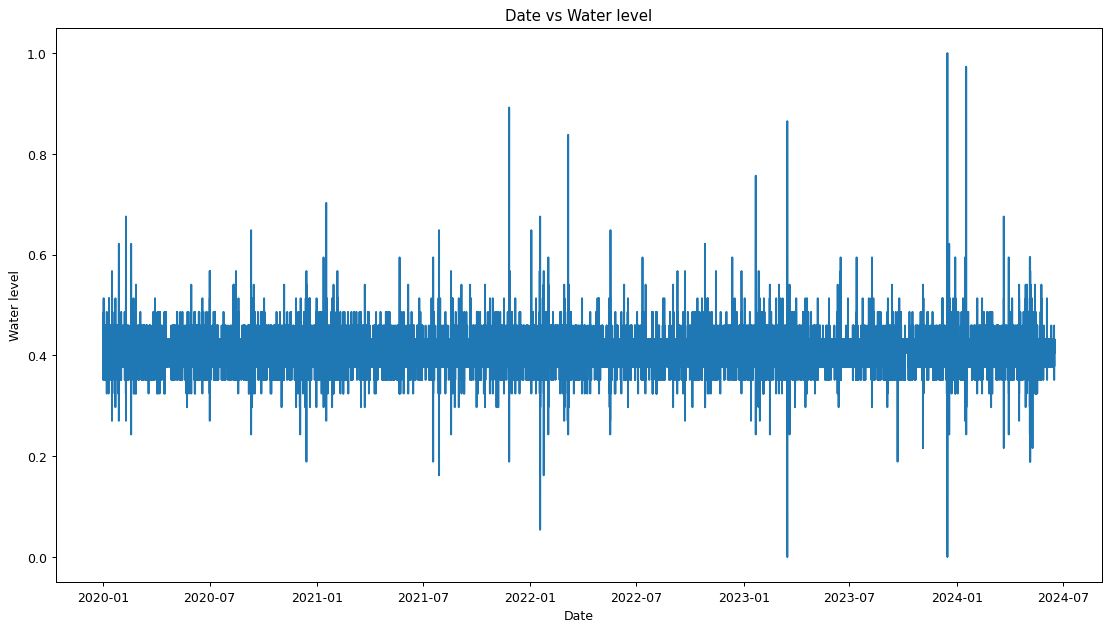

In [ ]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
start_date_train = '2023-01-01 00:15:00'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

In [ ]:
df_train

,level_cm_lag_1_scaled
date_time,
2020-01-01 00:15:00,0.459459
2020-01-01 00:30:00,0.405405
2020-01-01 00:45:00,0.378378
2020-01-01 01:00:00,0.405405
2020-01-01 01:15:00,0.405405
...,...
2022-12-31 23:15:00,0.378378
2022-12-31 23:30:00,0.405405
2022-12-31 23:45:00,0.405405


In [ ]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-01 00:30:00,0.405405
2023-01-01 00:45:00,0.405405
2023-01-01 01:00:00,0.378378
2023-01-01 01:15:00,0.378378
2023-01-01 01:30:00,0.405405
...,...
2024-06-15 23:00:00,0.432432
2024-06-15 23:15:00,0.432432
2024-06-15 23:30:00,0.405405


### AUTO ARMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1, start_q=1,
                   max_p=5, max_q=5,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-516526.978, Time=67.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-508634.672, Time=16.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-510865.002, Time=23.44 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-510082.753, Time=43.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=108896.937, Time=4.74 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-527337.452, Time=158.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-519700.897, Time=33.37 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-526575.854, Time=80.06 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-526839.844, Time=228.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-525268.475, Time=75.56 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-525884.303, Time=41.67 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-527888.222, Time=130.37 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-528636.671, Time=168.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-52

RMSE e MSE

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

2023-01-01 00:30:00    0.398966
2023-01-01 00:45:00    0.393682
2023-01-01 01:00:00    0.393781
2023-01-01 01:15:00    0.396351
2023-01-01 01:30:00    0.398408
                         ...   
2024-06-15 23:00:00    0.405401
2024-06-15 23:15:00    0.405401
2024-06-15 23:30:00    0.405401
2024-06-15 23:45:00    0.405401
2024-06-16 00:00:00    0.405401
Freq: 15T, Length: 51071, dtype: float64

In [ ]:
conf_int

array([[0.36051419, 0.43741762],
       [0.35522894, 0.43213446],
       [0.35448946, 0.43307243],
       ...,
       [0.36310759, 0.44769527],
       [0.36310759, 0.44769527],
       [0.36310759, 0.44769527]])

In [ ]:
# forecast = forecast.values

# forecast_inversed = scaler.inverse_transform(forecast.reshape(-1, 1))
# conf_int_inversed = scaler.inverse_transform(conf_int)

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

AttributeError: 'numpy.ndarray' object has no attribute 'values'